# Insurance Decision Prediction with XGBoost


The Workflow of the project:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Let's begin by installing the required libraries.

## Problem Statement

This project takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Prudential Life Insurance Assessment](https://www.kaggle.com/c/prudential-life-insurance-assessment) competition on Kaggle:

>Prudential, one of the largest issuers of life insurance in the USA.

> In a one-click shopping world with on-demand everything, the life insurance application process is antiquated. Customers provide extensive information to identify risk classification and eligibility, including scheduling medical exams, a process that takes an average of 30 days.

>By developing a predictive model that accurately classifies risk using a more automated approach, you can greatly impact public perception of the industry.

> View and download the data here: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [ ]:
import os
import opendatasets as od
import numpy as np 
import opendatasets
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [ ]:
od.download('https://www.kaggle.com/c/prudential-life-insurance-assessment/data')

Skipping, found downloaded files in "./prudential-life-insurance-assessment" (use force=True to force download)


You'll be asked to provide your Kaggle credentials to download the data. Follow these instructions: http://bit.ly/kaggle-creds

In [ ]:
os.listdir('prudential-life-insurance-assessment')

['train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']

Let's load the data into Pandas dataframes.

In [ ]:
train_df = pd.read_csv('./prudential-life-insurance-assessment/train.csv.zip', low_memory=False)

In [ ]:
train_df.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,...,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,3,3,240.0,3,3,1,1,2,1,2,...,3,NaN,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,3,3,0.0,1,3,1,1,2,1,2,...,3,NaN,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,...,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,...,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,...,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [ ]:
train_df.describe()

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,...,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59362.000000,59381.000000,59381.000000,52602.000000,59381.000000,48527.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,33985.000000,59381.000000,59381.000000,59381.000000,59381.000000,30725.000000,25140.000000,40197.000000,17570.000000,50492.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,557.000000,59381.000000,59381.000000,59381.000000,59381.000000,14785.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,1107.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,0.469462,0.077582,8.641821,1.300904,0.006283,2.142958,0.361469,1.209326,2.007427,5.835840,2.883666,1.027180,1.409188,1.038531,1.727606,1.055792,2.146983,1.958707,0.001733,1.901989,2.048484,2.419360,2.686230,0.474550,0.497737,0.44489

In [ ]:
train_df.dropna()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,...,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response


In [ ]:
train_missing = train_df.isna()
train_num_missing = train_missing.sum()

In [ ]:
a=pd.DataFrame(train_num_missing,columns=['null_count'])
a['total']=len(train_df)
a['percentage_missing']=(a['null_count']/a['total'])*100

In [ ]:
a[a.null_count>0]

,null_count,total,percentage_missing
Employment_Info_1,19,59381,0.031997
Employment_Info_4,6779,59381,11.416110
Employment_Info_6,10854,59381,18.278574
Insurance_History_5,25396,59381,42.767889
Family_Hist_2,28656,59381,48.257860
Family_Hist_3,34241,59381,57.663226
Family_Hist_4,19184,59381,32.306630
Family_Hist_5,41811,59381,70.411411
Medical_History_1,8889,59381,14.969435
Medical_History_10,58824,59381,99.061990


######removing such columns where percentage of missing value is more than 30 percent

In [ ]:
train_new=train_df.drop(['Medical_History_32','Medical_History_24','Medical_History_15','Medical_History_10',
                      'Family_Hist_5','Family_Hist_3','Family_Hist_2','Insurance_History_5'], axis=1)
train_new.shape

(59381, 120)

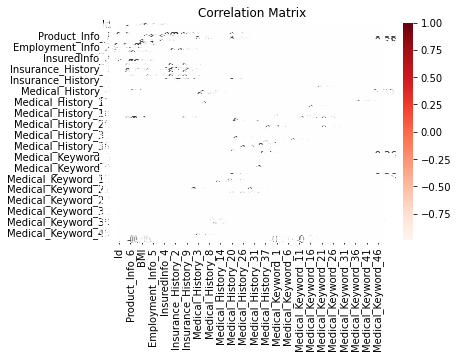

In [ ]:
import seaborn as sns
sns.heatmap(train_new.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

### Input and Target Columns

Let's select the columns that we'll use for training.

In [ ]:
X = train_new.drop(['Id', 'Response'], axis=1)
y = train_new['Response']

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [ ]:
import numpy as np
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes('object').columns.tolist()

### Impute missing numerical data

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean').fit(train_new[numeric_cols])
X[numeric_cols] = imputer.transform(X[numeric_cols])
print(X[numeric_cols].isna().sum())

Product_Info_1         0
Product_Info_3         0
Product_Info_4         0
Product_Info_5         0
Product_Info_6         0
Product_Info_7         0
Ins_Age                0
Ht                     0
Wt                     0
BMI                    0
Employment_Info_1      0
Employment_Info_2      0
Employment_Info_3      0
Employment_Info_4      0
Employment_Info_5      0
Employment_Info_6      0
InsuredInfo_1          0
InsuredInfo_2          0
InsuredInfo_3          0
InsuredInfo_4          0
InsuredInfo_5          0
InsuredInfo_6          0
InsuredInfo_7          0
Insurance_History_1    0
Insurance_History_2    0
Insurance_History_3    0
Insurance_History_4    0
Insurance_History_7    0
Insurance_History_8    0
Insurance_History_9    0
Family_Hist_1          0
Family_Hist_4          0
Medical_History_1      0
Medical_History_2      0
Medical_History_3      0
Medical_History_4      0
Medical_History_5      0
Medical_History_6      0
Medical_History_7      0
Medical_History_8      0


### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_new[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_new[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
X[encoded_cols] = encoder.transform(X[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [ ]:
X = X[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, train_targets, val_targets = train_test_split(X, y, test_size=0.1)
X_train.shape

(53442, 136)

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 




For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Hyperparameter Tuning and Regularization before training the best fit model

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [ ]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [ ]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params).fit(X_train, train_targets)
    train_rmse = math.sqrt(mean_squared_error(model.predict(X_train), train_targets))
    val_rmse = math.sqrt(mean_squared_error(model.predict(X_val), val_targets))
    return train_rmse, val_rmse

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

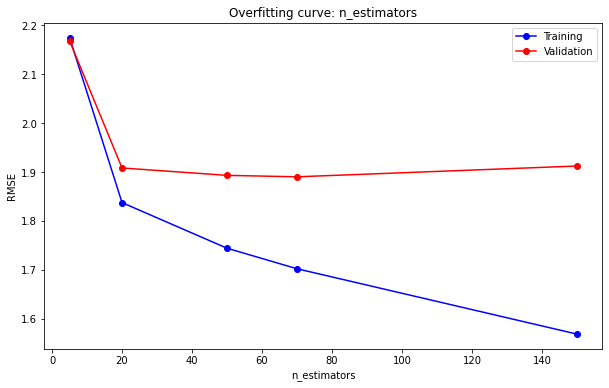

In [ ]:
test_param_and_plot('n_estimators', [5,20,50,70,150])

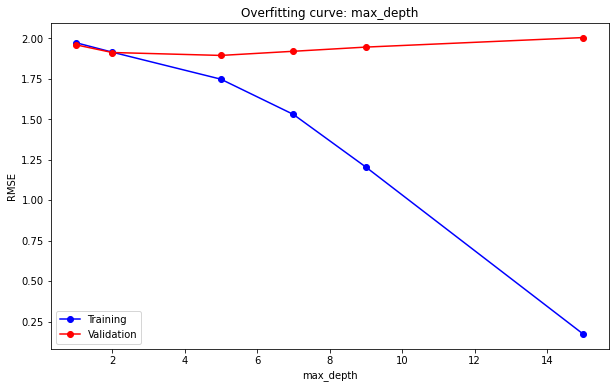

In [ ]:
test_param_and_plot('max_depth', [1,2,5,7,9,15])

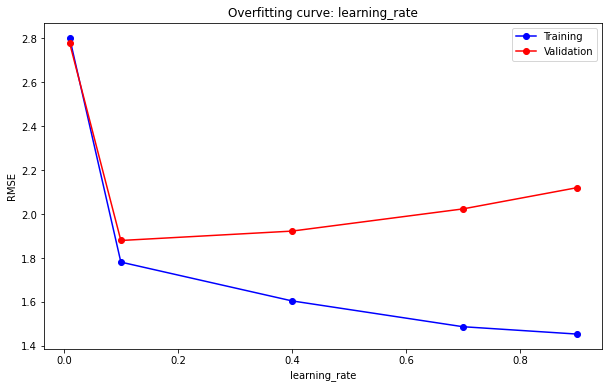

In [ ]:
test_param_and_plot('learning_rate', [0.01,0.1,0.4,0.7,0.9])

In [ ]:
test_params(n_estimators=20, learning_rate=0.1)

(2.055593394830152, 2.058609669189514)

In [ ]:
test_params(n_estimators=20, learning_rate=0.5)

(1.7995406874443067, 1.9136067863039694)

In [ ]:
test_params(n_estimators=60, learning_rate=0.5,max_depth=4)

(1.8285763179187187, 1.9036502275527114)

##Models Defining

In [ ]:
from sklearn.linear_model import LinearRegression
LR_Model = LinearRegression()
XG_model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=60, max_depth=4,learning_rate=0.5)

Let's train the model using `model.fit`.

In [ ]:
%%time
LR_Model.fit(X_train,train_targets)
XG_model.fit(X_train, train_targets)

CPU times: user 20.3 s, sys: 188 ms, total: 20.5 s
Wall time: 10.5 s


In [ ]:
#LR_model rmse
LR_train_rmse = math.sqrt(mean_squared_error(LR_Model.predict(X_train), train_targets))
LR_val_rmse = math.sqrt(mean_squared_error(LR_Model.predict(X_val), val_targets))
#XG_model rmse
XG_train_rmse = math.sqrt(mean_squared_error(XG_model.predict(X_train), train_targets))
XG_val_rmse = math.sqrt(mean_squared_error(XG_model.predict(X_val), val_targets))

In [ ]:
rmse_df = pd.DataFrame({
    'Models': ['Linear Regression','XGBoost'],
    'Train_Rmse' : [LR_train_rmse,XG_train_rmse],
    'Validation_Rmse' : [LR_val_rmse,XG_val_rmse],
})

In [ ]:
rmse_df

,Models,Train_Rmse,Validation_Rmse
0,Linear Regression,1.969683,1.960936
1,XGBoost,1.828576,1.903650


###Make a function that will make test data ready for testing

In [ ]:
def test_ready(test_df,LR_model,XG_model):
  test_df.dropna()
  test_new = test_df.drop(['Id','Medical_History_32','Medical_History_24','Medical_History_15','Medical_History_10',
                      'Family_Hist_5','Family_Hist_3','Family_Hist_2','Insurance_History_5'], axis=1)
  numeric_cols = test_new.select_dtypes(include=np.number).columns.tolist()
  categorical_cols = test_new.select_dtypes('object').columns.tolist()
  imputer = SimpleImputer(strategy = 'mean').fit(test_new[numeric_cols])
  test_new[numeric_cols] = imputer.transform(test_new[numeric_cols])
  scaler = MinMaxScaler().fit(test_new[numeric_cols])
  test_new[numeric_cols] = scaler.transform(test_new[numeric_cols])
  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(test_new[categorical_cols])
  encoded_cols = list(encoder.get_feature_names(categorical_cols))
  test_new[encoded_cols] = encoder.transform(test_new[categorical_cols])
  test_new = test_new[numeric_cols + encoded_cols]
  LR_preds = LR_model.predict(test_new)
  XG_preds = XG_model.predict(test_new)
  return LR_preds,XG_preds

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [ ]:
test_df = pd.read_csv('./prudential-life-insurance-assessment/test.csv.zip')

In [ ]:
test_ready(test_df,LR_Model,XG_model)

(array([3.24438477, 5.56140137, 5.06274414, ..., 2.91967773, 3.88378906,
        4.44470215]),
 array([3.421553 , 5.9189095, 6.174068 , ..., 3.862232 , 3.3355374,
        5.1471715], dtype=float32))

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a LinearRegression and gradient boosting model using XGBoost
- Configuring the gradient boosting model and tuning hyperparamters
- Predicted the outputs for Test set
Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html